In [2]:
# Neccesary imports
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from time import time
import random
import glob, os

# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from scipy.ndimage.filters import gaussian_filter1d
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from accelerate import Accelerator
cm = plt.get_cmap('RdYlBu')
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import LayerNorm
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.colors as mcolors


/tmp/ipykernel_1400202/4140597471.py:17: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

In [49]:
!free -g

               total        used        free      shared  buff/cache   available
Mem:             376          33         333           0          10         342
Swap:              1           0           1


In [1]:
%%time
# Import all the data

data = pd.read_pickle('~/research/galax_spec/grism_specPT.pkl')

NameError: name 'pd' is not defined

In [4]:
data = data[data['SNR']>=2.5]
data_subset = data[data['z']<1.7]
data_subset

,grism_id,wavelength,flux,z,SNR,continuum_sub_flux
2,aegis-26-G141_00469,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.43,4.094828,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,aegis-26-G141_00703,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.40,20.695364,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,aegis-26-G141_00836,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.56,6.308725,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,aegis-26-G141_00910,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.05,4.627907,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,aegis-26-G141_00937,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.51,8.418367,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
18575,uds-23-G141_42763,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002...",1.34,4.185430,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002..."
18576,uds-05-G141_42909,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.45,2.974790,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18577,uds-25-G141_42927,"[10208.409432389317, 10209.33721533346, 10210....","[0.11972591812810127, 0.11699151816036778, 0.1...",0.99,3.177632,"[0.11903046440555565, 0.11629269513745405, 0.1..."
18578,uds-25-G141_42956,"[10208.409432389317, 10209.33721533346, 10210....","[0.10640179127421547, 0.10492161739585708, 0.1...",0.92,3.127168,"[0.10595676034947163, 0.10447454305889436, 0.1..."


In [5]:
# Split the data into 70% train and 30% temp_test
train_df, temp_test_df = train_test_split(data_subset, test_size=0.3, random_state=42)

# Split the temp_test into 50% test and 50% validation, which is 15% each of the original
test_df, val_df = train_test_split(temp_test_df, test_size=0.5, random_state=42)

print(len(train_df),len(test_df),len(val_df))

6078 1302 1303


In [6]:
cd galax_spec

/home/ckb2084/research/galax_spec


/home/ckb2084/conda/envs/pytorch/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
from SpecPT import (
    SpecPT, 
    SpecPTForRedshift, 
    CustomLoadDataset_Autoencoder,
    Swish,
    # CustomLoadDataset_Redshift, 
    NMADLoss, 
    evaluate
)

In [8]:
class EnhancedSpecPTForRedshift(nn.Module):
    def __init__(self, pretrained_model, output_features=1, num_mlp_blocks=5, mlp_dim=512, dropout_rate=0.2):
        super(EnhancedSpecPTForRedshift, self).__init__()
        
        self.encoder = pretrained_model.transformer_encoder
        self.proj_to_d_model = pretrained_model.proj_to_d_model
        self.forward_conv = pretrained_model.forward_conv
        
        # Fine-tune the last few layers of the encoder
        for param in list(self.encoder.parameters())[-4:]:
            param.requires_grad = True
        
        self.mlp_blocks = nn.Sequential(
            *[ImprovedResidualMLPBlock(mlp_dim if i > 0 else 512, mlp_dim, dropout_rate) for i in range(num_mlp_blocks)]
        )
        
        self.prediction = nn.Sequential(
            nn.Linear(mlp_dim, mlp_dim // 2),
            Swish(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_dim // 2, output_features),
            nn.Softplus()
        )
        
        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=8)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.forward_conv(x)
        x = x.flatten(start_dim=1)
        x = self.proj_to_d_model(x)
        x = x.unsqueeze(0)
        
        encoded_features = self.encoder(x)
        encoded_features = encoded_features.squeeze(0)
        
        # Apply attention mechanism
        attn_output, _ = self.attention(encoded_features, encoded_features, encoded_features)
        x = attn_output + encoded_features  # Residual connection
        
        x = self.mlp_blocks(x)
        redshift = self.prediction(x)
        return redshift

class ImprovedResidualMLPBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate):
        super(ImprovedResidualMLPBlock, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.swish = Swish()
        self.layer_norm = nn.LayerNorm(output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        residual = x
        x = self.swish(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = x + residual  # Residual connection
        x = self.layer_norm(x)
        return self.swish(x)


In [9]:
# Dataset Loader for Redshift
class CustomLoadDataset_Redshift(Dataset):
    def __init__(self, df):
        x = []
        y = []
        target_id = []
            
        for index, row in df.iterrows():
            fl = row['flux']
            if np.median(fl) > 0:
                fl = fl / np.median(fl)
                x.append(fl)
                y.append(np.array([row['z']]))
                target_id.append(row['grism_id'])

        self.X = torch.from_numpy(np.stack(x, axis=0))
        self.Y = torch.from_numpy(np.stack(y, axis=0))
        self.t_id = target_id

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.Y[idx].float(), idx, self.t_id[idx]


In [10]:
valid_loader = DataLoader(CustomLoadDataset_Redshift(val_df), batch_size=100, shuffle=True)
test_loader = DataLoader(CustomLoadDataset_Redshift(test_df), batch_size=256, shuffle=False)

In [11]:
# Define CNN hyper-parameters

n=1
epochs = 800
batch_size = 64
lr = 1e-5 #orig = 0.001 or 1e-3, best with 5e-5

config = {
    "input_size": 7781,
    "d_model": 512,
    "nhead": 8,
    "num_encoder_layers": 3,
    "num_decoder_layers": 3,
    "dim_feedforward": 2048,
    "learning_rate": lr,
    "batch_size": 64,
    "num_mlp_blocks": 5,
    "mlp_dim": 512,
    "dropout_rate": 0.2
}

In [12]:
train_loader = DataLoader(CustomLoadDataset_Redshift(train_df), batch_size=batch_size, shuffle=True)

In [24]:
accelerator = Accelerator()

model = SpecPT(input_size=7781) #, d_head=16
# model.load_state_dict(torch.load('redshift_prediction_model_1D_large_kernel_staggered_training.pth'))

# Load the model state
file_path = os.path.expanduser('~/research/galax_spec/pretrained_weights')
# state_dict = torch.load(f'{file_path}/SpecPT_DESI_combined_autoencoder_150.pth', map_location='cpu')  # Load to CPU first 
state_dict = torch.load(f'{file_path}/SpecPT_training_HST_150.pth', map_location='cpu')  # Load to CPU first 
model.load_state_dict(state_dict)
model.to(accelerator.device)
# Initialize the modified SpecPT model for redshift prediction
# redshift_model = SpecPTForRedshift(model)  # `model` is the pretrained SpecPT instance
redshift_model = EnhancedSpecPTForRedshift(
    model, 
    output_features=1, 
    num_mlp_blocks=config["num_mlp_blocks"], 
    mlp_dim=config["mlp_dim"], 
    dropout_rate=config["dropout_rate"]
)

# Load the model state
# state_dict = torch.load('../SpecPT_DESI_BGS_redshift_prediction_model_complex_MLP_residual_2.pth', map_location='cpu')  # Load to CPU first
# state_dict = torch.load('saved_models/SpecPT_HST_redshift_model_400.pth', map_location='cpu')  # Load to CPU first
state_dict = torch.load(f'{file_path}/SpecPT_DESI_Combined_EnhancedSpecPTForRedshift_500.pth', map_location='cpu')  # Load to CPU first
redshift_model.load_state_dict(state_dict)

/tmp/ipykernel_1280447/451698165.py:9: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_1280447/451698165.py:25: FutureWarning:

You are using `torch.load` with 

<All keys matched successfully>

In [ ]:
pwd

'/home/ckb2084/research/galax_spec'

eta =  57.029388403494835
rmse =  0.49552440622802496
rmse/(1+z) =  0.2512920650819316
nmad =  0.2598347357391197
nmad2 =  0.2445701957652148


/tmp/ipykernel_1280447/4687696.py:164: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



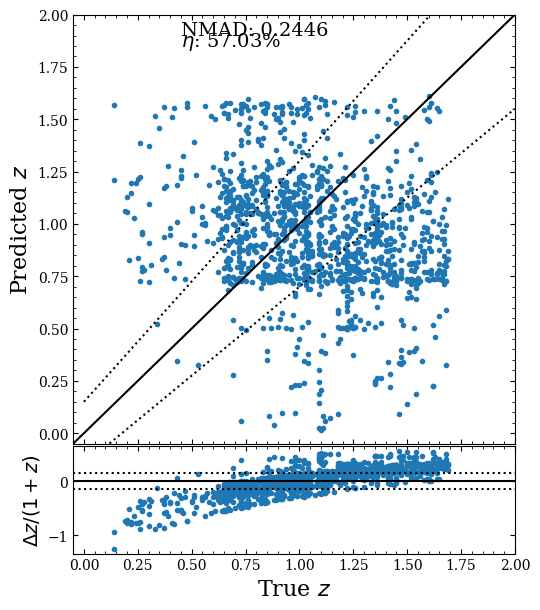

In [25]:
from functools import reduce
import operator
# Initialize the Accelerator
accelerator = Accelerator()

# model = SpecPT(input_size=7781) #, d_head=16
# # model.load_state_dict(torch.load('redshift_prediction_model_1D_large_kernel_staggered_training.pth'))

# # Load the model state
# file_path = os.path.expanduser('~/research/galax_spec/pretrained_weights')
# state_dict = torch.load(f'{file_path}/SpecPT_DESI_combined_autoencoder_150.pth', map_location='cpu') 
# # state_dict = torch.load('saved_models/SpecPT_training_HST_150.pth', map_location='cpu')  # Load to CPU first 
# model.load_state_dict(state_dict)
# model.to(accelerator.device)
# # Initialize the modified SpecPT model for redshift prediction
# # redshift_model = SpecPTForRedshift(model)  # `model` is the pretrained SpecPT instance
# redshift_model = EnhancedSpecPTForRedshift(
#     model, 
#     output_features=1, 
#     num_mlp_blocks=config["num_mlp_blocks"], 
#     mlp_dim=config["mlp_dim"], 
#     dropout_rate=config["dropout_rate"]
# )

# # Load the model state
# file_path = os.path.expanduser('~/research/galax_spec/pretrained_weights')
# state_dict = torch.load(f'{file_path}/SpecPT_DESI_Combined_EnhancedSpecPTForRedshift_500.pth', map_location='cpu') 

# # state_dict = torch.load('saved_models/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_'+str(epochs*n)+'.pth', map_location='cpu')  # Load to CPU first
# redshift_model.load_state_dict(state_dict)

# Prepare the model and data loader using Accelerator
redshift_model, test_loader = accelerator.prepare(redshift_model, test_loader)
redshift_model = redshift_model.to(accelerator.device)
redshift_model.eval()


# model = model.to(DEVICE)
# model.eval()
# true = []
# preds = []
# with torch.no_grad():
#     for X, Y in test_loader:
#         X, Y = X.to(DEVICE), Y.to(DEVICE)
#         output = model(X)
#         for xx,yy in zip(Y.cpu().numpy().reshape((len(Y.cpu()),)),output.cpu().numpy().reshape((len(output.cpu()),))):
#             true.append(xx)
#             preds.append(yy)


# model = model.to(DEVICE)
true_class = []
preds_class = []
true_z = []
preds_z = []
indices = []
target_ids = []
with torch.no_grad():
    for X, Y, idx, t_id in test_loader:
#         X, Y = X.to(DEVICE), Y.to(DEVICE)
        output = redshift_model(X)
        true_z.extend(reduce(operator.concat, Y.tolist()))
        preds_z.extend(reduce(operator.concat, output.tolist()))
        # Assuming the first element of Y and output corresponds to class, and the second to z value
#         for y, out in zip(Y.tolist(), output.tolist()):
#             true_class.append(y[0])  # Assuming y[0] is class
#             preds_class.append(out[0])  # Assuming out[0] is predicted class
#             true_z.append(y[1])  # Assuming y[1] is z
#             preds_z.append(out[1])  # Assuming out[1] is predicted z
        indices.extend(idx.tolist())
        target_ids.extend(list(t_id))
#         for xx,yy in zip(Y.cpu().numpy().reshape((len(Y.cpu()),2)),output.cpu().numpy().reshape((len(output.cpu()),2))):
#             true_z.append(xx[1])
#             preds_z.append(yy[1])
#             true_class.append(xx[0])temp_df = pd.DataFrame({'index': indices, 'preds_z': preds_z, 'true_z': true_z})

temp_df = pd.DataFrame({'index': indices, 'grism_id': target_ids, 'preds_z': preds_z, 'true_z': true_z})
df_results_main = temp_df
df_results_main = df_results_main.set_index(['index'])
df_results_main.index.name = None
df_results_main

df_results = pd.merge(test_df, df_results_main, on='grism_id')
# df_results = temp_df
# df_results = df_results[df_results['target']!=-1]

# Load your data here
# df_results = pd.read_csv('../results_8Sep22_lr.001_ep32_flux_and_wl_norm.csv')
from matplotlib.gridspec import GridSpec
plt.rcdefaults()

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# df_results = df_results.sort_values(by='ZQUALITY',ascending=False)
# df_results = df_results[df_results['ZQUALITY']==4]

fig = plt.figure(figsize=(5.7, 7))
gs = GridSpec(2, 1, height_ratios=[4, 1], wspace=0.1,hspace=0.01) #width_ratios=[10, 1]

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
# cax = fig.add_subplot(gs[:, 1])


delz = (df_results['true_z']-df_results['preds_z'])/(1+df_results['true_z'])
delta = (df_results['true_z']-df_results['preds_z'])
nmad = 1.48*np.median(np.abs(delz))
nmad2 = 1.48*np.median(np.abs((delta - np.median(delta))/(1+df_results['true_z'])))
# print(nmad)
rmse = np.sqrt(np.mean(delz**2))
frac = 0.15
eta = 100*len(delz[np.abs(delz)>frac])/len(delz)
print('eta = ',eta)
print('rmse = ',np.sqrt(np.mean((df_results['true_z']-df_results['preds_z'])**2)))
print('rmse/(1+z) = ',rmse)
print('nmad = ',nmad)
print('nmad2 = ',nmad2)
# rmse2 = np.sqrt(np.mean((df_results['true']-df_results['predicted'])**2))
min_lim = -0.05
max_lim = np.ceil(df_results['true_z'].max())#7
avg = (min_lim+max_lim)/2
ax1.text(min_lim+0.5,max_lim-0.1,r'NMAD: '+str(np.round(nmad2,4)),fontdict={'size':14})
ax1.text(min_lim+0.5,max_lim-0.15,r'$\eta$: '+str(np.round(eta,2))+'%',fontdict={'size':14})
ax1.plot([min_lim,max_lim],[min_lim,max_lim],zorder=9,c='k')

x = np.linspace(0,np.ceil(df_results['z'].max()))
y1 = ((1+x)*frac)+x
y2 = ((1+x)*-frac)+x
ax1.plot(x,y1,zorder=9,c='k',linestyle='dotted')
ax1.plot(x,y2,zorder=9,c='k',linestyle='dotted')

# Plot the first subplot with color
sc1 = ax1.scatter(df_results['true_z'], df_results['preds_z'], zorder=8, marker='.')
ax1.set_ylabel(r'Predicted $z$', fontsize=16)
# xspace = np.linspace(0.1,6.1)
# print(xspace)
# ax1.plot(0.15*(xspace),0.15*xspace,linestyle='dotted',c='k')
# ax1.plot(xspace,0.15*(1+xspace),linestyle='dotted',c='k')
ax1.set_xlim(min_lim, max_lim)
ax1.set_ylim(min_lim, max_lim)
ax1.minorticks_on()

# Plot the second subplot with color
sc2 = ax2.scatter(df_results['true_z'], delz, zorder=8, marker='.')
ax2.axhline(y=0, c='k', zorder=9, linestyle='solid')
ax2.axhline(y=-frac, c='k', zorder=9, linestyle='dotted')
ax2.axhline(y=frac, c='k', zorder=9, linestyle='dotted')
ax2.set_ylabel(r'$\Delta z/(1+z)$', fontsize=14)
ax2.set_xlabel(r'True $z$', fontsize=16)
# ax2.set_ylim(-0.22,0.22)

# Remove x-tick labels for ax1
plt.setp(ax1.get_xticklabels(), visible=False)

# # Create a single color bar for both subplots
# cbar = plt.colorbar(sc1, cax=cax, orientation='vertical', pad=0.02)
# cbar.set_label('Confidence/Probability', fontsize=14)  # Customize the color bar label

# Adjust the layout
plt.tight_layout()

# Save or show the plot
# plt.savefig('../results_8Sep22_lr.001_ep32_flux_and_wl_norm.png', dpi=1200)
plt.show()

In [26]:

criterion = NMADLoss(normalization_factor='std')



optimizer = torch.optim.Adam(redshift_model.parameters(), lr=config["learning_rate"])
# Define different learning rates for different parts of the model
# lr_encoder = 1e-6  # Learning rate for pre-trained encoder layers
# lr_new_layers = 1e-4  # Learning rate for new layers (MLP and attention)

# # Split the model's parameters into different groups
# optimizer = torch.optim.Adam([
#     {'params': redshift_model.encoder.parameters(), 'lr': lr_encoder},  # Pre-trained encoder with a smaller learning rate
#     {'params': redshift_model.proj_to_d_model.parameters(), 'lr': lr_encoder},  # Pre-trained projection layer
#     # {'params': redshift_model.forward_conv.parameters(), 'lr': lr_encoder},  # Pre-trained forward convolution layer
#     {'params': redshift_model.mlp_blocks.parameters(), 'lr': lr_new_layers},  # New MLP blocks with a higher learning rate
#     {'params': redshift_model.prediction.parameters(), 'lr': lr_new_layers},  # New prediction layers with a higher learning rate
#     {'params': redshift_model.attention.parameters(), 'lr': lr_new_layers}  # New attention layers with a higher learning rate
# ])


# Initialize Accelerator

redshift_model, train_loader, valid_loader, optimizer, criterion = accelerator.prepare(redshift_model, train_loader, valid_loader, optimizer, criterion)


import wandb

wandb.login()



# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="SpecPT_HST",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "batch_size": 64,
    "architecture": "Enhanced SpecPT HST Redshift",
    "dataset": "HST (DESI combined)",
    "epochs": "0-800",
    "criterion": "NMAD(std)",
    }
)

In [27]:
start_time = time()
best_val_loss, overfit, patience = np.inf, 0, 1200
t_loss = []
v_loss = []
for epoch in range(epochs):
#     model.zero_grad()
    redshift_model.train()
    alpha_mean = {}
    train_loss = 0.0
    for step, (X, Y, idx, t_id) in enumerate(train_loader):
#         X, Y = X.to(DEVICE), Y.to(DEVICE)
#         model.zero_grad()
        pred = redshift_model(X)
        loss = criterion(pred, Y)
        train_loss += loss.item()
        
        
        
        # Backward pass and optimize
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

    train_loss /= len(train_loader.dataset)
    # print('Epoch:', epoch, '\n\tTrain loss:', train_loss)
    t_loss.append(train_loss)
    np.savetxt('train_loss_HST_redshift_model_DESI_combined_PT_Enhanced_'+str(epochs*n)+'.txt',np.array(t_loss))
    
#     train_time = time()
#     temp = train_time-start_time
#     hours = temp//3600
#     temp = temp - 3600*hours
#     minutes = temp//60
#     seconds = temp - 60*minutes
#     print('Time elapsed since start:')
#     print('%dh%dm%ds' %(hours,minutes,seconds))

    # Early stopping
    redshift_model.eval() #Added extra!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    if valid_loader is not None:
        val_loss = evaluate(redshift_model, valid_loader, criterion, accelerator)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(redshift_model.state_dict(), 'saved_models/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_'+str(epochs*n)+'.pth')
            overfit = 0
        else:
            overfit += 1
            if overfit >= patience:
                redshift_model.load_state_dict(torch.load('saved_models/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_'+str(epochs*n)+'.pth'))
                break
        # print('\tVal Loss:', val_loss)
        # print('\tBest Val Loss:', best_val_loss)
        # print('\tBest Epoch:', best_epoch)
        # log metrics to wandb
        # wandb.log({"val_loss": val_loss, "train_loss": train_loss, "best_epoch": best_epoch})
        v_loss.append(val_loss)
        np.savetxt('val_loss_HST_redshift_model_DESI_combined_PT_Enhanced_'+str(epochs*n)+'.txt',np.array(v_loss))
        val_time = time()
        if epoch ==0:
            completion_time = epochs*n*(val_time-start_time)
            hours = completion_time//3600
            completion_time = completion_time - 3600*hours
            minutes = completion_time//60
            seconds = completion_time - 60*minutes
            print('Estimated Completion Time:')
            print('%dh%dm%ds' %(hours,minutes,seconds))
            print('\n')
        temp = val_time-start_time
        hours = temp//3600
        temp = temp - 3600*hours
        minutes = temp//60
        seconds = temp - 60*minutes

        print('Epoch:', epoch, '\n\tTrain loss:', train_loss)
        print('\tVal Loss:', val_loss)
        print('\tBest Val Loss:', best_val_loss)
        print('\tBest Epoch:', best_epoch)
        print('Time elapsed since start:')
        print('%dh%dm%ds' %(hours,minutes,seconds))
        if np.isnan(train_loss):
            print("Loss is NaN. Stopping training.")
            break  
            
# wandb.finish()

Estimated Completion Time:
0h33m55s


Epoch: 0 
	Train loss: 0.017216712312547296
	Val Loss: 0.00935828685760498
	Best Val Loss: 0.00935828685760498
	Best Epoch: 0
Time elapsed since start:
0h0m2s
Epoch: 1 
	Train loss: 0.014769101900251125
	Val Loss: 0.008769565608661637
	Best Val Loss: 0.008769565608661637
	Best Epoch: 1
Time elapsed since start:
0h0m5s
Epoch: 2 
	Train loss: 0.013561267439378138
	Val Loss: 0.008289105194830611
	Best Val Loss: 0.008289105194830611
	Best Epoch: 2
Time elapsed since start:
0h0m7s
Epoch: 3 
	Train loss: 0.013136964095266242
	Val Loss: 0.008206342944043427
	Best Val Loss: 0.008206342944043427
	Best Epoch: 3
Time elapsed since start:
0h0m10s
Epoch: 4 
	Train loss: 0.012743532718537594
	Val Loss: 0.00806199792816705
	Best Val Loss: 0.00806199792816705
	Best Epoch: 4
Time elapsed since start:
0h0m12s
Epoch: 5 
	Train loss: 0.012579139575217535
	Val Loss: 0.008000394478145795
	Best Val Loss: 0.008000394478145795
	Best Epoch: 5
Time elapsed since start:
0h0m1

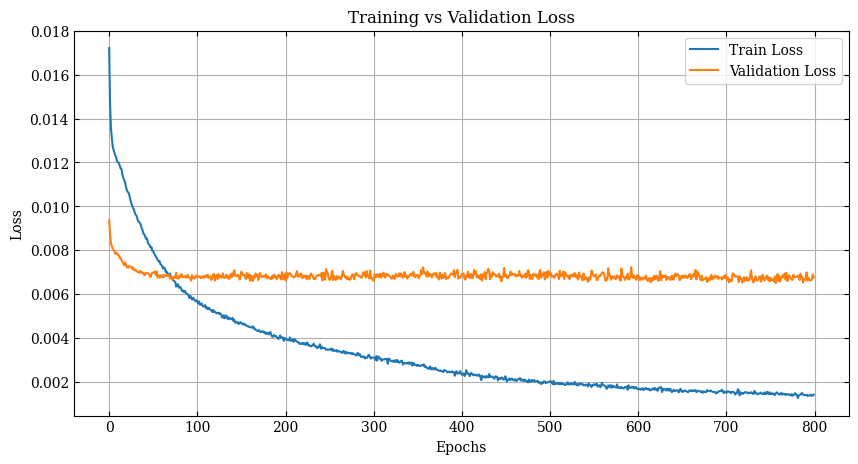

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Train Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
torch.save(redshift_model.state_dict(), 'saved_models/SpecPT_HST_redshift_model_'+str((epochs*n)+1)+'.pth')

/home/ckb2084/conda/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)

/tmp/ipykernel_1280447/2420478281.py:13: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

eta =  29.467831612390786
rmse =  0.32525135273042993
rmse/(1+z) =  0.17178320130171743
nmad =  0.0722307501530176
nmad2 =  0.07312932618556951


/tmp/ipykernel_1280447/2420478281.py:165: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



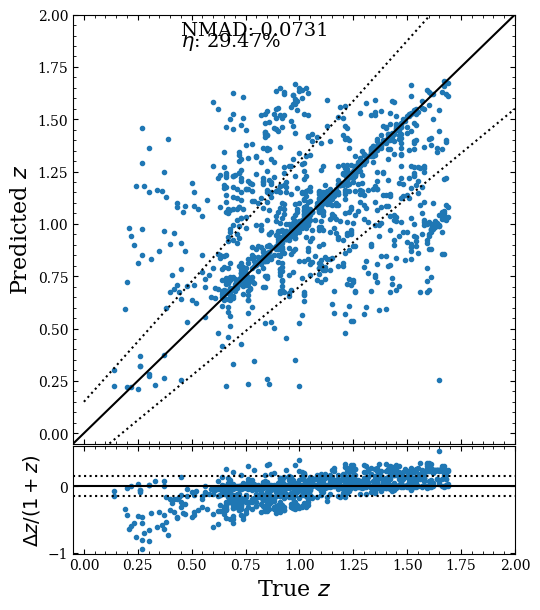

In [ ]:
from functools import reduce
import operator
# Initialize the Accelerator
accelerator = Accelerator()

model = SpecPT(input_size=7781) #, d_head=16
# model.load_state_dict(torch.load('redshift_prediction_model_1D_large_kernel_staggered_training.pth'))

# Load the model state
# state_dict = torch.load('saved_models/SpecPT_training_HST_150.pth', map_location='cpu')  # Load to CPU first 
file_path = os.path.expanduser('~/research/galax_spec/pretrained_weights')
# state_dict = torch.load(f'{file_path}/SpecPT_DESI_combined_autoencoder_150.pth', map_location='cpu')
state_dict = torch.load(f'{file_path}/SpecPT_training_HST_150.pth', map_location='cpu')

model.load_state_dict(state_dict)
model.to(accelerator.device)
# Initialize the modified SpecPT model for redshift prediction
# redshift_model = SpecPTForRedshift(model)  # `model` is the pretrained SpecPT instance
redshift_model = EnhancedSpecPTForRedshift(
    model, 
    output_features=1, 
    num_mlp_blocks=config["num_mlp_blocks"], 
    mlp_dim=config["mlp_dim"], 
    dropout_rate=config["dropout_rate"]
)

# Load the model state
state_dict = torch.load('saved_models/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_'+str(epochs*n)+'.pth', map_location='cpu')  # Load to CPU first
# state_dict = torch.load('pretrained_weights/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_'+'500.pth', map_location='cpu')  # Load to CPU first

redshift_model.load_state_dict(state_dict)

# Prepare the model and data loader using Accelerator
redshift_model, test_loader = accelerator.prepare(redshift_model, test_loader)
redshift_model = redshift_model.to(accelerator.device)
redshift_model.eval()


# model = model.to(DEVICE)
# model.eval()
# true = []
# preds = []
# with torch.no_grad():
#     for X, Y in test_loader:
#         X, Y = X.to(DEVICE), Y.to(DEVICE)
#         output = model(X)
#         for xx,yy in zip(Y.cpu().numpy().reshape((len(Y.cpu()),)),output.cpu().numpy().reshape((len(output.cpu()),))):
#             true.append(xx)
#             preds.append(yy)


# model = model.to(DEVICE)
true_class = []
preds_class = []
true_z = []
preds_z = []
indices = []
target_ids = []
with torch.no_grad():
    for X, Y, idx, t_id in test_loader:
#         X, Y = X.to(DEVICE), Y.to(DEVICE)
        output = redshift_model(X)
        true_z.extend(reduce(operator.concat, Y.tolist()))
        preds_z.extend(reduce(operator.concat, output.tolist()))
        # Assuming the first element of Y and output corresponds to class, and the second to z value
#         for y, out in zip(Y.tolist(), output.tolist()):
#             true_class.append(y[0])  # Assuming y[0] is class
#             preds_class.append(out[0])  # Assuming out[0] is predicted class
#             true_z.append(y[1])  # Assuming y[1] is z
#             preds_z.append(out[1])  # Assuming out[1] is predicted z
        indices.extend(idx.tolist())
        target_ids.extend(list(t_id))
#         for xx,yy in zip(Y.cpu().numpy().reshape((len(Y.cpu()),2)),output.cpu().numpy().reshape((len(output.cpu()),2))):
#             true_z.append(xx[1])
#             preds_z.append(yy[1])
#             true_class.append(xx[0])temp_df = pd.DataFrame({'index': indices, 'preds_z': preds_z, 'true_z': true_z})

temp_df = pd.DataFrame({'index': indices, 'grism_id': target_ids, 'preds_z': preds_z, 'true_z': true_z})
df_results_main = temp_df
df_results_main = df_results_main.set_index(['index'])
df_results_main.index.name = None
df_results_main

df_results = pd.merge(test_df, df_results_main, on='grism_id')
# df_results = temp_df
# df_results = df_results[df_results['target']!=-1]

# Load your data here
# df_results = pd.read_csv('../results_8Sep22_lr.001_ep32_flux_and_wl_norm.csv')
from matplotlib.gridspec import GridSpec
plt.rcdefaults()

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# df_results = df_results.sort_values(by='ZQUALITY',ascending=False)
# df_results = df_results[df_results['ZQUALITY']==4]

fig = plt.figure(figsize=(5.7, 7))
gs = GridSpec(2, 1, height_ratios=[4, 1], wspace=0.1,hspace=0.01) #width_ratios=[10, 1]

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
# cax = fig.add_subplot(gs[:, 1])


delz = (df_results['true_z']-df_results['preds_z'])/(1+df_results['true_z'])
delta = (df_results['true_z']-df_results['preds_z'])
nmad = 1.48*np.median(np.abs(delz))
nmad2 = 1.48*np.median(np.abs((delta - np.median(delta))/(1+df_results['true_z'])))
# print(nmad)
rmse = np.sqrt(np.mean(delz**2))
frac = 0.15
eta = 100*len(delz[np.abs(delz)>frac])/len(delz)
print('eta = ',eta)
print('rmse = ',np.sqrt(np.mean((df_results['true_z']-df_results['preds_z'])**2)))
print('rmse/(1+z) = ',rmse)
print('nmad = ',nmad)
print('nmad2 = ',nmad2)
# rmse2 = np.sqrt(np.mean((df_results['true']-df_results['predicted'])**2))
min_lim = -0.05
max_lim = np.ceil(df_results['true_z'].max())#7
avg = (min_lim+max_lim)/2
ax1.text(min_lim+0.5,max_lim-0.1,r'NMAD: '+str(np.round(nmad2,4)),fontdict={'size':14})
ax1.text(min_lim+0.5,max_lim-0.15,r'$\eta$: '+str(np.round(eta,2))+'%',fontdict={'size':14})
ax1.plot([min_lim,max_lim],[min_lim,max_lim],zorder=9,c='k')

x = np.linspace(0,np.ceil(df_results['z'].max()))
y1 = ((1+x)*frac)+x
y2 = ((1+x)*-frac)+x
ax1.plot(x,y1,zorder=9,c='k',linestyle='dotted')
ax1.plot(x,y2,zorder=9,c='k',linestyle='dotted')

# Plot the first subplot with color
sc1 = ax1.scatter(df_results['true_z'], df_results['preds_z'], zorder=8, marker='.')
ax1.set_ylabel(r'Predicted $z$', fontsize=16)
# xspace = np.linspace(0.1,6.1)
# print(xspace)
# ax1.plot(0.15*(xspace),0.15*xspace,linestyle='dotted',c='k')
# ax1.plot(xspace,0.15*(1+xspace),linestyle='dotted',c='k')
ax1.set_xlim(min_lim, max_lim)
ax1.set_ylim(min_lim, max_lim)
ax1.minorticks_on()

# Plot the second subplot with color
sc2 = ax2.scatter(df_results['true_z'], delz, zorder=8, marker='.')
ax2.axhline(y=0, c='k', zorder=9, linestyle='solid')
ax2.axhline(y=-frac, c='k', zorder=9, linestyle='dotted')
ax2.axhline(y=frac, c='k', zorder=9, linestyle='dotted')
ax2.set_ylabel(r'$\Delta z/(1+z)$', fontsize=14)
ax2.set_xlabel(r'True $z$', fontsize=16)
# ax2.set_ylim(-0.22,0.22)

# Remove x-tick labels for ax1
plt.setp(ax1.get_xticklabels(), visible=False)

# # Create a single color bar for both subplots
# cbar = plt.colorbar(sc1, cax=cax, orientation='vertical', pad=0.02)
# cbar.set_label('Confidence/Probability', fontsize=14)  # Customize the color bar label

# Adjust the layout
plt.tight_layout()

# Save or show the plot
# plt.savefig('../results_8Sep22_lr.001_ep32_flux_and_wl_norm.png', dpi=1200)
plt.show()

In [31]:
# # Calculate necessary values
# delz = (bgs_results['true_z'] - bgs_results['preds_z']) / (1 + bgs_results['true_z'])
# delta = bgs_results['true_z'] - bgs_results['preds_z']
# nmad = 1.48 * np.median(np.abs(delz))
# nmad2 = 1.48 * np.median(np.abs((delta - np.median(delta)) / (1 + bgs_results['true_z'])))
# rmse = np.sqrt(np.mean(delz**2))
# frac = 0.15
# eta = 100 * len(delz[np.abs(delz) > frac]) / len(delz)

# Print statistics
print(f'eta = {eta}')
print(f'rmse = {np.sqrt(np.mean((df_results["true_z"] - df_results["preds_z"])**2))}')
print(f'rmse/(1+z) = {rmse}')
print(f'nmad = {nmad}')
print(f'nmad2 = {nmad2}')

# Set up the figure with subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02,
                    row_heights=[0.8, 0.2])

# Define axis limits
min_lim = -0.05
# max_lim = np.ceil(bgs_results['true_z'].max())
max_lim = df_results['true_z'].max()+0.1

# Add scatter plot to the first subplot
fig.add_trace(
    go.Scatter(
        x=df_results['true_z'], 
        y=df_results['preds_z'], 
        mode='markers',
        marker=dict(size=2, color='steelblue', opacity=0.5),
        name='Data points',
        hovertemplate='<b>TARGETID</b>: %{customdata}<br>' +
                      '<b>True z</b>: %{x:.4f}<br>' +
                      '<b>Predicted z</b>: %{y:.4f}<br>',
        customdata=df_results['grism_id']
    ),
    row=1, col=1
)

# Add identity line
fig.add_trace(
    go.Scatter(x=[min_lim, max_lim], y=[min_lim, max_lim], mode='lines', 
               line=dict(color='black', width=0.5), name='y=x'),
    row=1, col=1
)

# Add dotted lines
# x = np.linspace(0, np.ceil(bgs_results['true_z'].max()), 100)
x = np.linspace(0, df_results['true_z'].max()+0.1, 100)
y1 = ((1 + x) * frac) + x
y2 = ((1 + x) * -frac) + x

fig.add_trace(
    go.Scatter(x=x, y=y1, mode='lines', line=dict(color='black', dash='dot'), 
               showlegend=False),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=x, y=y2, mode='lines', line=dict(color='black', dash='dot'), 
               showlegend=False),
    row=1, col=1
)

# Add scatter plot to the second subplot
fig.add_trace(
    go.Scatter(
        x=df_results['true_z'], 
        y=delz, 
        mode='markers',
        marker=dict(size=2, color='steelblue', opacity=0.5),
        name='Δz/(1+z)',
        hovertemplate='<b>TARGETID</b>: %{customdata}<br>' +
                      '<b>True z</b>: %{x:.4f}<br>' +
                      '<b>Δz/(1+z)</b>: %{y:.4f}<br>',
        customdata=df_results['grism_id']
    ),
    row=2, col=1
)

# Add horizontal lines to the second subplot
fig.add_hline(y=0, line=dict(color='black', width=0.5), row=2, col=1)
fig.add_hline(y=frac, line=dict(color='black', dash='dot'), row=2, col=1)
fig.add_hline(y=-frac, line=dict(color='black', dash='dot'), row=2, col=1)

# Update layout
fig.update_layout(
    height=700, width=570,
#     title_text='Redshift Prediction Results',
    showlegend=False,
    annotations=[
        dict(
            x=0.05, y=0.95,
            xref='paper', yref='paper',
            text=f'NMAD: {nmad2:.4f}<br>η: {eta:.2f}%',
            showarrow=False,
            font=dict(size=14, color='black')
        )
    ],
    plot_bgcolor='white',
    margin=dict(l=50, r=50, t=50, b=50)
)

# Update axes
fig.update_xaxes(title_text='True z', row=2, col=1, title_font=dict(size=18, color='black'))
fig.update_yaxes(title_text='Predicted z', row=1, col=1, title_font=dict(size=18, color='black'))
fig.update_yaxes(title_text='Δz/(1+z)', row=2, col=1, title_font=dict(size=18, color='black'))

fig.update_xaxes(
    showline=True,  # Show the line on the x-axis
    tickfont=dict(size=14, color='black'), 
    linecolor='black',  # Color of the x-axis line
    linewidth=2,  # Width of the x-axis line
    mirror='allticks',  # Mirror axis line and ticks on the opposite side (top)
    ticks='inside',  # Position ticks inside the plot
)
fig.update_yaxes(
    showline=True,  # Show the line on the y-axis
    tickfont=dict(size=14, color='black'), 
    linecolor='black',  # Color of the y-axis line
    linewidth=2,  # Width of the y-axis line
    mirror='allticks',  # Mirror axis line and ticks on the opposite side (right)
    ticks='inside',  # Position ticks inside the plot
)


# Update axes limits
fig.update_xaxes(range=[min_lim, max_lim], row=1, col=1)
fig.update_yaxes(range=[min_lim, max_lim], row=1, col=1)

# Show the plot
fig.show()

eta = 29.467831612390786
rmse = 0.32525135273042993
rmse/(1+z) = 0.17178320130171743
nmad = 0.0722307501530176
nmad2 = 0.07312932618556951


In [32]:


# # Calculate necessary values (same as before)
# delz = (bgs_results['true_z'] - bgs_results['preds_z']) / (1 + bgs_results['true_z'])
# delta = bgs_results['true_z'] - bgs_results['preds_z']
# nmad = 1.48 * np.median(np.abs(delz))
# nmad2 = 1.48 * np.median(np.abs((delta - np.median(delta)) / (1 + bgs_results['true_z'])))
# rmse = np.sqrt(np.mean(delz**2))
# frac = 0.15
# eta = 100 * len(delz[np.abs(delz) > frac]) / len(delz)

# r2score_bgs = np.round(r2_score(bgs_results['true_z'],bgs_results['preds_z']),2)

# Set up the figure with subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.01,
                    row_heights=[0.8, 0.2])

# Define axis limits
min_lim = -0.05
max_lim = df_results['true_z'].max() + 0.1

# Calculate 2D kernel density estimation
x = df_results['true_z']
y = df_results['preds_z']
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Add scatter plot with very low opacity
fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        mode='markers',
        marker=dict(size=2, color='steelblue', opacity=0.5),
        name='Data points',
        hovertemplate='<b>TARGETID</b>: %{customdata}<br>' +
                      '<b>True z</b>: %{x:.4f}<br>' +
                      '<b>Predicted z</b>: %{y:.4f}<br>',
        customdata=df_results['grism_id']
    ),
    row=1, col=1
)

# Add 2D contour plot to the first subplot
fig.add_trace(
    go.Histogram2dContour(
        x=x,
        y=y,
        zmin=1,
        colorscale='blues',
        reversescale=True,
        xaxis='x',
        yaxis='y',
        name='Density',
        showscale=False,
        contours=dict(
            showlabels=False,
            coloring='lines',
            labelfont=dict(size=12, color='black')
        ),
        line=dict(color='black',width=4)
    ),
    row=1, col=1
)



# Add identity line
fig.add_trace(
    go.Scatter(x=[min_lim, max_lim], y=[min_lim, max_lim], mode='lines', 
               line=dict(color='black', width=0.5), name='y=x'),
    row=1, col=1
)

# Add dotted lines
x_line = np.linspace(0, max_lim, 100)
y1 = ((1 + x_line) * frac) + x_line
y2 = ((1 + x_line) * -frac) + x_line
fig.add_trace(
    go.Scatter(x=x_line, y=y1, mode='lines', line=dict(color='black', dash='dot'), 
               showlegend=False),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=x_line, y=y2, mode='lines', line=dict(color='black', dash='dot'), 
               showlegend=False),
    row=1, col=1
)

# Add scatter plot to the second subplot
fig.add_trace(
    go.Scatter(
        x=df_results['true_z'], 
        y=delz, 
        mode='markers',
        marker=dict(size=2, color='steelblue', opacity=0.5),
        name='Δz/(1+z)',
        hovertemplate='<b>TARGETID</b>: %{customdata}<br>' +
                      '<b>True z</b>: %{x:.4f}<br>' +
                      '<b>Δz/(1+z)</b>: %{y:.4f}<br>',
        customdata=df_results['grism_id']
    ),
    row=2, col=1
)

# Add horizontal lines to the second subplot
fig.add_hline(y=0, line=dict(color='black', width=0.5), row=2, col=1)
fig.add_hline(y=frac, line=dict(color='black', dash='dot'), row=2, col=1)
fig.add_hline(y=-frac, line=dict(color='black', dash='dot'), row=2, col=1)

# Update layout
fig.update_layout(
    height=700, width=570,
#     title_text='Redshift Prediction Results',
    showlegend=False,
    annotations=[
        dict(
            x=0.05, y=0.95,
            xref='paper', yref='paper',
#             text=f'R<sup>2</sup> score: {r2score_bgs:.2f}',
            text=f'NMAD: {nmad2:.4f}<br>η: {eta:.2f}%',
            showarrow=False,
            font=dict(size=14,color='black')
        )
    ],
    plot_bgcolor='white',
    margin=dict(l=50, r=20, t=20, b=50)
)

# Update axes
fig.update_xaxes(title_text='True z', row=2, col=1, title_font=dict(size=18, color='black'))
fig.update_yaxes(title_text='Predicted z', row=1, col=1, title_font=dict(size=18, color='black'))
fig.update_yaxes(title_text='Δz/(1+z)', row=2, col=1, title_font=dict(size=18, color='black'))

# # Remove all grid lines from both subplots
# fig.update_xaxes(showgrid=False, zeroline=False)
# fig.update_yaxes(showgrid=False, zeroline=False)
# Update axes to add boundaries on all sides and tick marks inside
fig.update_xaxes(
    showline=True,  # Show the line on the x-axis
    tickfont=dict(size=14, color='black'), 
    linecolor='black',  # Color of the x-axis line
    linewidth=2,  # Width of the x-axis line
    mirror='allticks',  # Mirror axis line and ticks on the opposite side (top)
    ticks='inside',  # Position ticks inside the plot
    minor=dict(
        showgrid=False,  # No minor grid lines
        ticklen=4,  # Length of minor ticks
        tickcolor='black',  # Color of minor ticks
        ticks='inside'
    )
)
fig.update_yaxes(
    showline=True,  # Show the line on the y-axis
    tickfont=dict(size=14, color='black'), 
    linecolor='black',  # Color of the y-axis line
    linewidth=2,  # Width of the y-axis line
    mirror='allticks',  # Mirror axis line and ticks on the opposite side (right)
    ticks='inside',  # Position ticks inside the plot
    minor=dict(
        showgrid=False,  # No minor grid lines
        ticklen=2,  # Length of minor ticks
        tickcolor='black',  # Color of minor ticks
        ticks='inside'
    )
)

# Update axes limits
fig.update_xaxes(range=[min_lim, max_lim], row=1, col=1)
fig.update_yaxes(range=[min_lim, max_lim], row=1, col=1)

# Show the plot
fig.show()
# fig.write_image("Plots/BGS_redshift_results_density.pdf", format="pdf")

In [43]:
from sklearn.metrics import r2_score

r2score = np.round(r2_score(df_results['true_z'],df_results['preds_z']),2)
r2score

0.97

In [ ]:
pwd

'/home/ckb2084/research/galax_spec'